# About
This notebook generates all plots used in the paper.

# Imports and Setup

In [1]:
# lib
import sys
import numpy as np

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"

os.getcwd()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# set variables to keep track of
to_keep = set(
    [
        "path",
        "paths",
        "sim_params",
        "par1",
        "par2",
        "to_keep",
        "ou_trainables",
        "ouosc_trainables",
        "np",
        "sys",
        "os",
        "time",
    ]
)


def wipe_vars(additional_vars: set[str] = set()) -> None:
    """
    Delete all variables apart from those in to_keep, additional_vars, or those that are callable.
    """
    removed = []
    kept = []
    for var in list(globals().keys()):
        if (
            var not in to_keep.union(additional_vars)
            and not callable(globals()[var])
            and not var.startswith("_")
        ):
            removed.append(var)
            del globals()[var]
        else:
            kept.append(var)

    print(f"Removed variables: {removed}")
    print(f"Kept variables: {kept}")
    print(f"Number of variables: {len(globals())}")

# ROC

In [2]:
# ROC imports
from gpcell import plots

In [3]:
par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
n_cells = 50  # total replicates used in the simulation
t_final_vals = [1500, 600]  # 25/10 hours
noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]

In [4]:
# calculate ROC
fp1_vals, fp2_vals, tp1_vals, tp2_vals = [], [], [], []
for path, (noise, t_final, n_cells) in zip(paths, sim_params):
    fp1, tp1, fp2, tp2 = plots.compute_rocs_from_file(
        path, noise, n_cells, joblib=True, mcmc=True
    )
    fp1_vals.append(fp1)
    tp1_vals.append(tp1)
    fp2_vals.append(fp2)
    tp2_vals.append(tp2)


Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for set_noise
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 100 cells, noise set to 0.31622776601683794
Plots: on

Fitting MCMC...

Homogenous traces: 100 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:  3.2min


KeyboardInterrupt: 

=== Debug Info: Checking shapes and partial data ===
dataNORMED1 shape: (51, 100)
dataNORMED2 shape: (51, 100)
dataNORMED3 shape: (21, 100)
FP11[:5]: [1. 1. 1. 1. 1.] TP11[:5]: [1. 1. 1. 1. 1.]
FP21[:5]: [0.   0.   0.   0.02 0.02] TP21[:5]: [0.   0.02 0.12 0.12 0.22]
FP12[:5]: [1. 1. 1. 1. 1.] TP12[:5]: [1. 1. 1. 1. 1.]
FP22[:5]: [0.   0.   0.   0.02 0.02] TP22[:5]: [0.   0.02 0.22 0.22 0.26]
FP13[:5]: [1. 1. 1. 1. 1.] TP13[:5]: [1. 1. 1. 1. 1.]
FP23[:5]: [0.   0.   0.   0.02 0.02] TP23[:5]: [0.   0.02 0.06 0.06 0.18]


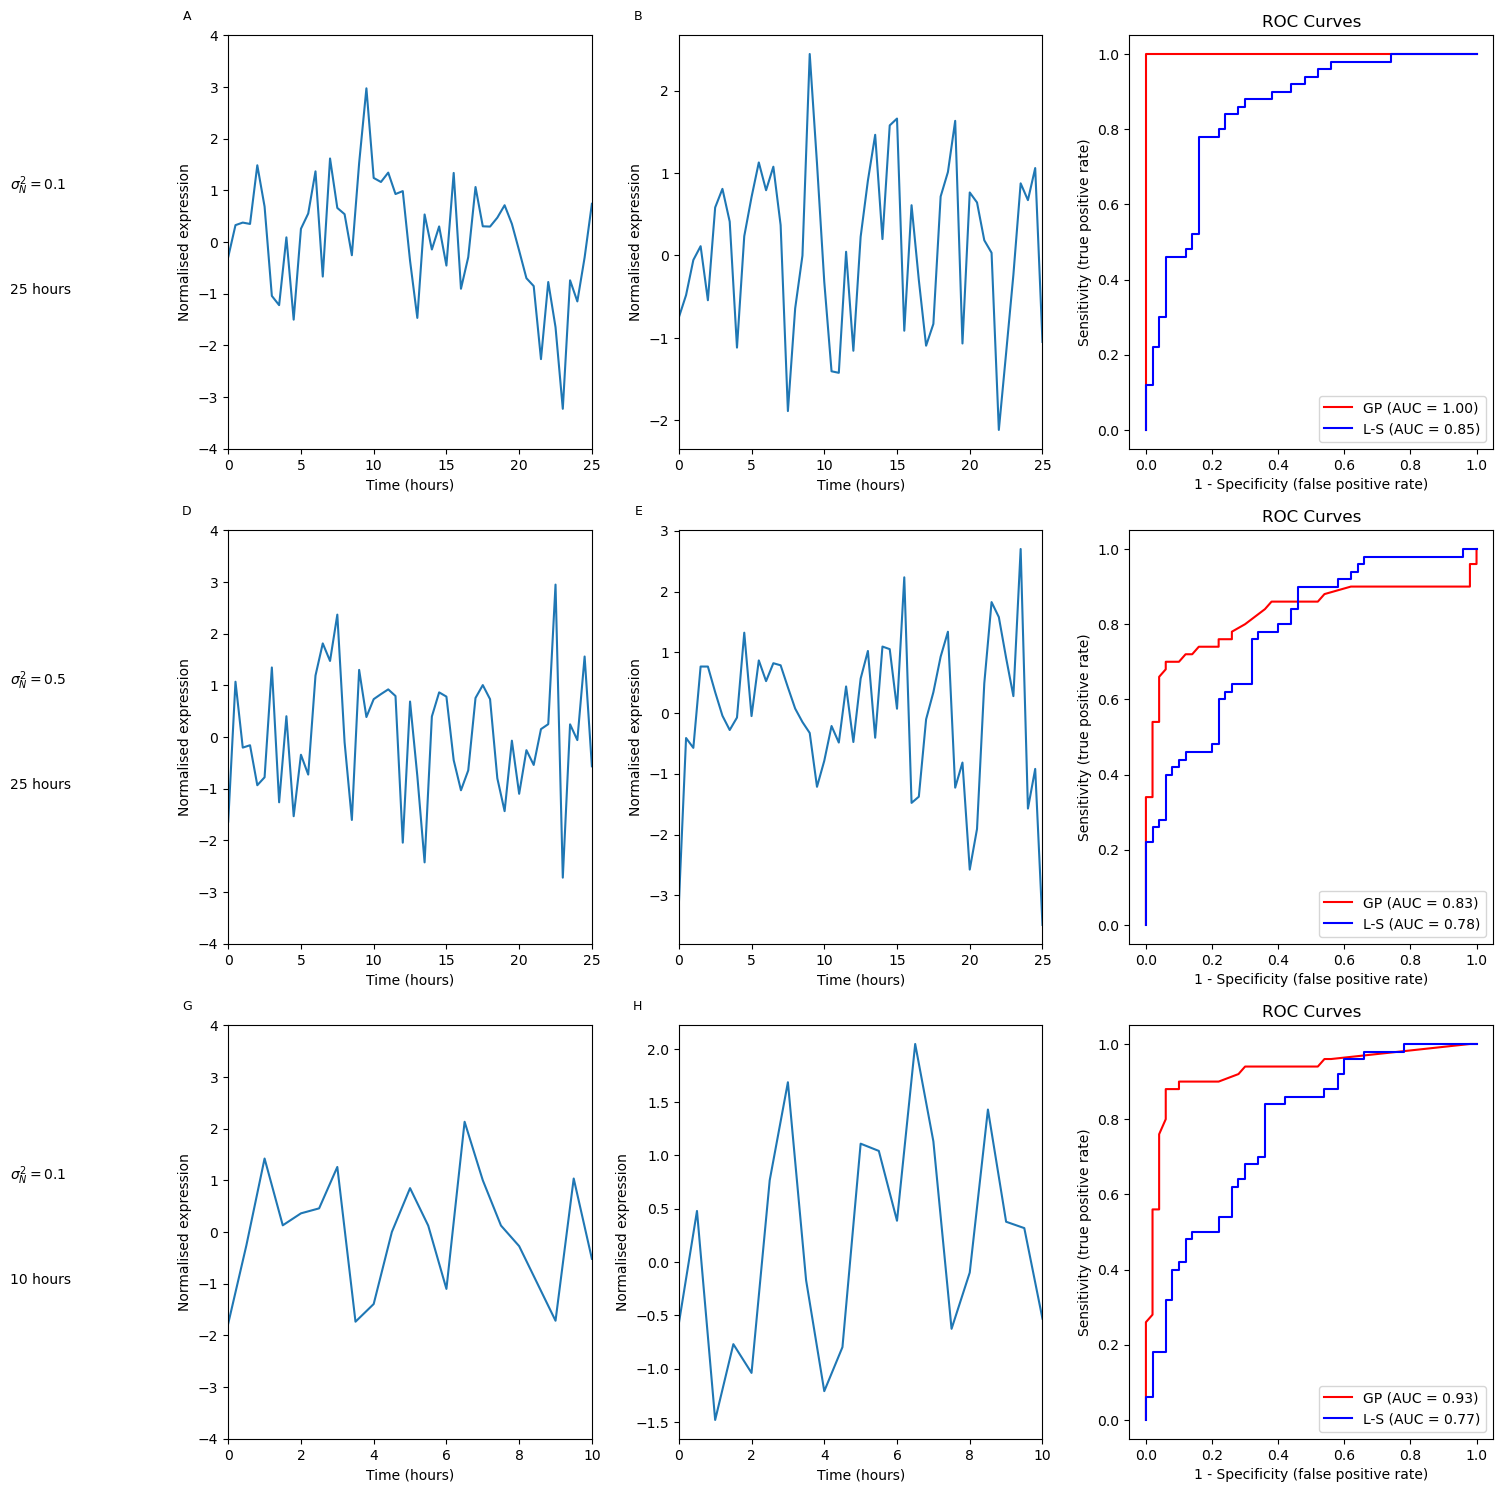

In [5]:
import pandas as pd

# plot ROC
x_arr = []
dataNormed_arr = []

for path in paths:
    df = pd.read_csv(path)

    x = df["Time"].values
    dataNormed = df.drop(columns=["Time"]).values

    x_arr.append(x)
    dataNormed_arr.append(dataNormed)

plots.plot_rocs_and_timeseries(
    x_arr[0],
    dataNormed_arr[0],
    fp1_vals[0],
    tp1_vals[0],
    fp2_vals[0],
    tp2_vals[0],
    x_arr[1],
    dataNormed_arr[1],
    fp1_vals[1],
    tp1_vals[1],
    fp2_vals[1],
    tp2_vals[1],
    x_arr[2],
    dataNormed_arr[2],
    fp1_vals[2],
    tp1_vals[2],
    fp2_vals[2],
    tp2_vals[2],
    n_cells,
)

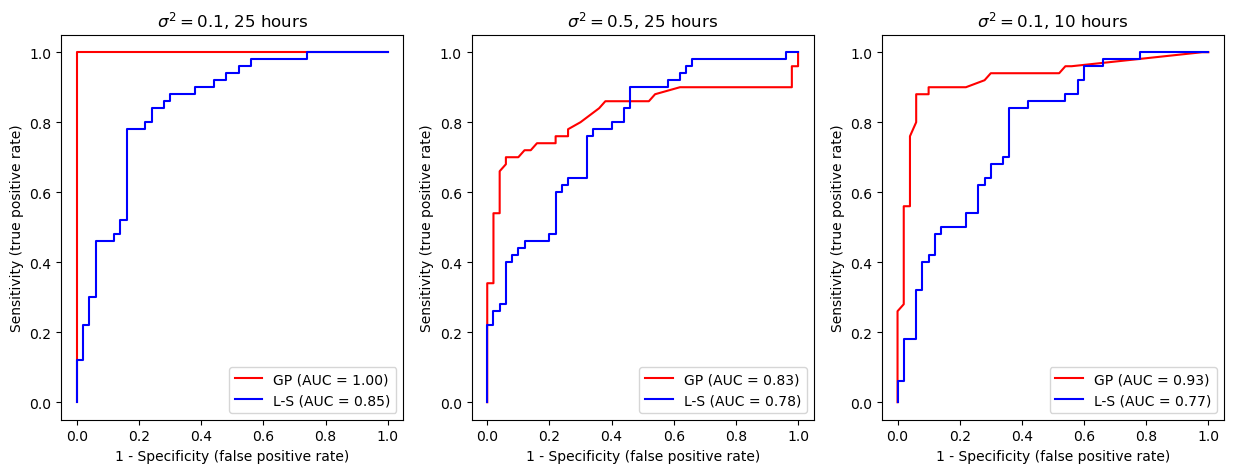

In [6]:
import matplotlib.pyplot as plt

# create 3 column horizontal figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
notes = [
    r"$\sigma^2=0.1$, 25 hours",
    r"$\sigma^2=0.5$, 25 hours",
    r"$\sigma^2=0.1$, 10 hours",
]

# plot ROC curves
for i, (fp1, tp1, fp2, tp2) in enumerate(zip(fp1_vals, tp1_vals, fp2_vals, tp2_vals)):
    plots.plot_roc(
        [fp1, fp2], [tp1, tp2], axes=axs[i], labels=["GP", "L-S"], note=notes[i]
    )

# Performance


In [7]:
# model fitting imports
from gpcell.utils import (
    load_data,
    fit_processes,
    fit_processes_joblib,
    detrend,
    background_noise,
)
from gpcell.backend import (
    ou_trainables,
    ouosc_trainables,
    hes_ou_prior,
    hes_ouosc_prior,
)
from gpflow.kernels import Matern12, Cosine
import time

wipe_vars()

Removed variables: ['In', 'Out', 'plots', 'n_cells', 't_final_vals', 'noise_vals', 'fp1_vals', 'fp2_vals', 'tp1_vals', 'tp2_vals', 'noise', 't_final', 'fp1', 'tp1', 'fp2', 'tp2', 'pd', 'x_arr', 'dataNormed_arr', 'df', 'x', 'dataNormed', 'plt', 'fig', 'axs', 'notes', 'i']
Kept variables: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '__DW_SCOPE__', '_i', '_ii', '_iii', '_i1', 'sys', 'np', 'os', 'path', 'to_keep', 'wipe_vars', '_i2', '_i3', 'par1', 'par2', 'sim_params', 'paths', '_i4', '_i5', '_i6', '_i7', 'load_data', 'fit_processes', 'fit_processes_joblib', 'detrend', 'background_noise', 'ou_trainables', 'ouosc_trainables', 'hes_ou_prior', 'hes_ouosc_prior', 'Matern12', 'Cosine', 'time']
Number of variables: 51


## Fitting models
### Hes data benchmark (12 non-homogenous cells)

In [8]:
# load data
path = "data/hes/Hes1_example.csv"
X_data_list, Y_data_list = load_data(path, "Time (h)", "Cell")
X_background_list, Y_background_list = load_data(path, "Time (h)", "Background")
num_cells = len(Y_data_list)
print(f"Loaded {num_cells} cells for analysis.")

Loaded 12 cells for analysis.


In [9]:
# preprocess
mean_noise, _ = background_noise(
    X_background_list, Y_background_list, 7.0, verbose=True
)
noise_list = [mean_noise / np.std(y) for y in Y_data_list]

Y_detrended_list, _ = detrend(X_data_list, Y_data_list, 7.0, verbose=True)

# define prior generators
ou_priors = [lambda noise=noise_list[i]: hes_ou_prior(noise) for i in range(num_cells)]
ouosc_priors = [
    lambda noise=noise_list[i]: hes_ouosc_prior(noise) for i in range(num_cells)
]

Background noise results:
Standard deviation: 7.302221575486058


In [10]:
from numpy import isnan, array, log


def BIC_diff(ou, ouosc, y):
    # extract log posterior density
    ou_LL = [gp.log_posterior() for gp in ou]
    ouosc_LL = [gp.log_posterior() for gp in ouosc]

    # filter nan's from model fitting
    ou_nan, ouosc_nan = isnan(ou_LL), isnan(ouosc_LL)
    ou_LL = array(ou_LL)[~ou_nan]
    ouosc_LL = array(ouosc_LL)[~ouosc_nan]

    # take process with highest posterior density
    max_ou_ll = max(ou_LL)
    max_ouosc_ll = max(ouosc_LL)

    # calculate LLR and BIC
    BIC_OUosc = -2 * max_ouosc_ll + 3 * log(len(y))
    BIC_OU = -2 * max_ou_ll + 2 * log(len(y))
    BIC_diff = BIC_OU - BIC_OUosc

    return BIC_diff


In [11]:
# --- time series fitting --- #

# fit processes without joblib
start = time.perf_counter()
ou_GPs = list(
    fit_processes(
        X_data_list,
        Y_detrended_list,
        Matern12,
        ou_priors,
        replicates=10,
        trainable=ou_trainables,
    )
)
ouosc_GPs = list(
    fit_processes(
        X_data_list,
        Y_detrended_list,
        [Matern12, Cosine],
        ouosc_priors,
        replicates=10,
        trainable=ouosc_trainables,
    )
)
end = time.perf_counter()

# extract values
base_python_time = end - start

# calculate LLR and BIC
BIC_diffs = []


for i, (x, y, ou, ouosc) in enumerate(
    zip(X_data_list, Y_detrended_list, ou_GPs, ouosc_GPs)
):
    BIC_diffs.append(BIC_diff(ou, ouosc, y))

del ou_GPs, ouosc_GPs

In [12]:
# joblib fitting
start = time.perf_counter()
ou_GPs = fit_processes_joblib(
    X_data_list,
    Y_detrended_list,
    Matern12,
    ou_priors,
    replicates=10,
    trainable=ou_trainables,
)
ouosc_GPs = fit_processes_joblib(
    X_data_list,
    Y_detrended_list,
    [Matern12, Cosine],
    ouosc_priors,
    replicates=10,
    trainable=ouosc_trainables,
)
end = time.perf_counter()

# extract values
joblib_time = end - start

# calculate BIC diff
BIC_diffs_joblib = []
for i, (x, y, ou, ouosc) in enumerate(
    zip(X_data_list, Y_detrended_list, ou_GPs, ouosc_GPs)
):
    BIC_diffs_joblib.append(BIC_diff(ou, ouosc, y))

# check if the results are the same
for i in range(num_cells):
    assert np.allclose(BIC_diffs[i], BIC_diffs_joblib[i]), f"Cell {i} results differ"
    print(
        f"Cell {i}: BIC diff = {BIC_diffs[i]:.2f} (Python) vs {BIC_diffs_joblib[i]:.2f} (joblib)"
    )
print(f"Base Python time: {base_python_time:.2f} seconds")
print(f"Joblib time: {joblib_time:.2f} seconds")


Small, non-homogenous traces: 12 cells

Small, non-homogenous traces: 12 cells
Cell 0: BIC diff = 3.27 (Python) vs 3.27 (joblib)
Cell 1: BIC diff = 11.65 (Python) vs 11.65 (joblib)
Cell 2: BIC diff = 13.95 (Python) vs 13.95 (joblib)
Cell 3: BIC diff = 11.64 (Python) vs 11.64 (joblib)
Cell 4: BIC diff = 8.14 (Python) vs 8.14 (joblib)
Cell 5: BIC diff = 18.56 (Python) vs 18.56 (joblib)
Cell 6: BIC diff = 4.81 (Python) vs 4.81 (joblib)
Cell 7: BIC diff = 15.53 (Python) vs 15.53 (joblib)
Cell 8: BIC diff = -2.92 (Python) vs -2.92 (joblib)
Cell 9: BIC diff = 5.25 (Python) vs 5.25 (joblib)
Cell 10: BIC diff = 6.26 (Python) vs 6.26 (joblib)
Cell 11: BIC diff = -0.69 (Python) vs -0.69 (joblib)
Base Python time: 37.98 seconds
Joblib time: 15.80 seconds


In [13]:
# save results and reset for next comparison
_base_hes = base_python_time
_joblib_hes = joblib_time

wipe_vars()

Removed variables: ['X_data_list', 'Y_data_list', 'X_background_list', 'Y_background_list', 'num_cells', 'mean_noise', 'noise_list', 'Y_detrended_list', 'ou_priors', 'ouosc_priors', 'start', 'end', 'base_python_time', 'BIC_diffs', 'i', 'x', 'y', 'ou', 'ouosc', 'ou_GPs', 'ouosc_GPs', 'joblib_time', 'BIC_diffs_joblib']
Kept variables: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '__DW_SCOPE__', '_i', '_ii', '_iii', '_i1', 'sys', 'np', 'os', 'path', 'to_keep', 'wipe_vars', '_i2', '_i3', 'par1', 'par2', 'sim_params', 'paths', '_i4', '_i5', '_i6', '_i7', 'load_data', 'fit_processes', 'fit_processes_joblib', 'detrend', 'background_noise', 'ou_trainables', 'ouosc_trainables', 'hes_ou_prior', 'hes_ouosc_prior', 'Matern12', 'Cosine', 'time', '_i8', '_i9', '_i10', 'isnan', 'array', 'log', 'BIC_diff', '_i11', '_i12', '_i13', '_base_hes', '_joblib_h

### 100 simulated homogenous cells

In [14]:
from gpcell.backend import sim_ou_prior, sim_ouosc_prior

# set cells on sim_params
n = 50
for i in range(len(sim_params)):
    sim_params[i][2] = n

# re-set paths
path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]

# load data
X, Y = load_data(paths[1], "Time", "Cell")
noise = sim_params[1][0]

# define prior generators
ou_priors = [lambda noise=noise: sim_ou_prior(noise) for _ in range(2 * n)]  # type: ignore
ouosc_priors = [lambda noise=noise: sim_ouosc_prior(noise) for _ in range(2 * n)]  # type: ignore

In [15]:
# --- time series fitting --- #

start = time.perf_counter()
ou_GPs = list(
    fit_processes(
        X,
        Y,
        Matern12,
        ou_priors,
        replicates=10,
        trainable=ou_trainables,
    )
)
ouosc_GPs = list(
    fit_processes(
        X,
        Y,
        [Matern12, Cosine],
        ouosc_priors,
        replicates=10,
        trainable=ouosc_trainables,
    )
)
end = time.perf_counter()

# extract values
base_python_time = end - start

# calculate LLR and BIC
BIC_diffs = []
for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
    BIC_diffs.append(BIC_diff(ou, ouosc, y))

del ou_GPs, ouosc_GPs

In [16]:
# joblib fitting
start = time.perf_counter()
ou_GPs = fit_processes_joblib(
    X,
    Y,
    Matern12,
    ou_priors,
    replicates=10,
    trainable=ou_trainables,
)
ouosc_GPs = fit_processes_joblib(
    X,
    Y,
    [Matern12, Cosine],
    ouosc_priors,
    replicates=10,
    trainable=ouosc_trainables,
)
end = time.perf_counter()

# extract values
joblib_time = end - start

# calculate BIC diff
BIC_diffs_joblib = []
for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
    BIC_diffs_joblib.append(BIC_diff(ou, ouosc, y))

# check if the results are the same
for i in range(len(BIC_diffs)):
    assert np.allclose(BIC_diffs[i], BIC_diffs_joblib[i]), f"Cell {i} results differ"
    print(
        f"Cell {i}: BIC diff = {BIC_diffs[i]:.2f} (Python) vs {BIC_diffs_joblib[i]:.2f} (joblib)"
    )

print(f"Base Python time: {base_python_time:.2f} seconds")
print(f"Joblib time: {joblib_time:.2f} seconds")

# save results and reset for next comparison
_base_sim = base_python_time
_joblib_sim = joblib_time
wipe_vars()

Cell 0: BIC diff = -4.46 (Python) vs -4.46 (joblib)
Base Python time: 318.08 seconds
Joblib time: 59.82 seconds
Removed variables: ['n', 'i', 'X', 'Y', 'noise', 'ou_priors', 'ouosc_priors', 'start', 'end', 'base_python_time', 'BIC_diffs', 'x', 'y', 'ou', 'ouosc', 'ou_GPs', 'ouosc_GPs', 'joblib_time', 'BIC_diffs_joblib']
Kept variables: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '__DW_SCOPE__', '_i', '_ii', '_iii', '_i1', 'sys', 'np', 'os', 'path', 'to_keep', 'wipe_vars', '_i2', '_i3', 'par1', 'par2', 'sim_params', 'paths', '_i4', '_i5', '_i6', '_i7', 'load_data', 'fit_processes', 'fit_processes_joblib', 'detrend', 'background_noise', 'ou_trainables', 'ouosc_trainables', 'hes_ou_prior', 'hes_ouosc_prior', 'Matern12', 'Cosine', 'time', '_i8', '_i9', '_i10', 'isnan', 'array', 'log', 'BIC_diff', '_i11', '_i12', '_i13', '_base_hes', '_jobli

In [19]:
n = 200

# set cells on sim_params
for i in range(len(sim_params)):
    sim_params[i][2] = n

# re-set paths
path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]

# load data
X, Y = load_data(paths[1], "Time", "Cell")
noise = sim_params[1][0]

# define prior generators
ou_priors = [lambda noise=noise: sim_ou_prior(noise) for _ in range(2 * n)]  # type: ignore
ouosc_priors = [lambda noise=noise: sim_ouosc_prior(noise) for _ in range(2 * n)]  # type: ignore


# --- time series fitting --- #
# start = time.perf_counter()
# ou_GPs = list(
#     fit_processes(
#         X,
#         Y,
#         Matern12,
#         ou_priors,
#         replicates=10,
#         trainable=ou_trainables,
#     )
# )
# ouosc_GPs = list(
#     fit_processes(
#         X,
#         Y,
#         [Matern12, Cosine],
#         ouosc_priors,
#         replicates=10,
#         trainable=ouosc_trainables,
#     )
# )
# end = time.perf_counter()

# extract values
# base_python_time = end - start

# calculate LLR and BIC
# BIC_diffs = []
# for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
#     BIC_diffs.append(BIC_diff(ou, ouosc, y))

# del ou_GPs, ouosc_GPs


# joblib fitting
start = time.perf_counter()
ou_GPs = fit_processes_joblib(
    X,
    Y,
    Matern12,
    ou_priors,
    replicates=10,
    trainable=ou_trainables,
)
ouosc_GPs = fit_processes_joblib(
    X,
    Y,
    [Matern12, Cosine],
    ouosc_priors,
    replicates=10,
    trainable=ouosc_trainables,
)
end = time.perf_counter()

# extract values
joblib_time = end - start

# calculate BIC diff
BIC_diffs_joblib = []
for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
    BIC_diffs_joblib.append(BIC_diff(ou, ouosc, y))

# check if the results are the same
for i in range(len(BIC_diffs)):
    assert np.allclose(BIC_diffs[i], BIC_diffs_joblib[i]), f"Cell {i} results differ"
    print(
        f"Cell {i}: BIC diff = {BIC_diffs[i]:.2f} (Python) vs {BIC_diffs_joblib[i]:.2f} (joblib)"
    )

# print(f"Base Python time: {base_python_time:.2f} seconds")
print(f"Joblib time: {joblib_time:.2f} seconds")
# save results and reset for next comparison
_base_sim_medium = base_python_time
_joblib_sim_medium = joblib_time
wipe_vars()

Joblib time: 189.26 seconds


NameError: name 'base_python_time' is not defined

### 1000 simulated homogenous cells

In [ ]:
n = 500

# set cells on sim_params
for i in range(len(sim_params)):
    sim_params[i][2] = n

# re-set paths
path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]

# load data
X, Y = load_data(paths[1], "Time", "Cell")
noise = sim_params[1][0]

# define prior generators
ou_priors = [lambda noise=noise: sim_ou_prior(noise) for _ in range(2 * n)]  # type: ignore
ouosc_priors = [lambda noise=noise: sim_ouosc_prior(noise) for _ in range(2 * n)]  # type: ignore


# 500 RAN UNTIL 90 MINUTES
# # --- time series fitting --- #
# start = time.perf_counter()
# ou_GPs = list(
#     fit_processes(
#         X,
#         Y,
#         Matern12,
#         ou_priors,
#         replicates=10,
#         trainable=ou_trainables,
#     )
# )
# ouosc_GPs = list(
#     fit_processes(
#         X,
#         Y,
#         [Matern12, Cosine],
#         ouosc_priors,
#         replicates=10,
#         trainable=ouosc_trainables,
#     )
# )
# end = time.perf_counter()

# # extract values
# base_python_time = end - start

# # calculate LLR and BIC
# BIC_diffs = []
# for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
#     BIC_diffs.append(BIC_diff(ou, ouosc, y))

# del ou_GPs, ouosc_GPs


# joblib fitting
start = time.perf_counter()
ou_GPs = fit_processes_joblib(
    X,
    Y,
    Matern12,
    ou_priors,
    replicates=10,
    trainable=ou_trainables,
)
ouosc_GPs = fit_processes_joblib(
    X,
    Y,
    [Matern12, Cosine],
    ouosc_priors,
    replicates=10,
    trainable=ouosc_trainables,
)
end = time.perf_counter()

# # extract values
# joblib_time = end - start

# # calculate BIC diff
# BIC_diffs_joblib = []
# for i, (x, y, ou, ouosc) in enumerate(zip([X], [Y], ou_GPs, ouosc_GPs)):
#     BIC_diffs_joblib.append(BIC_diff(ou, ouosc, y))

# # check if the results are the same
# for i in range(len(BIC_diffs)):
#     assert np.allclose(BIC_diffs[i], BIC_diffs_joblib[i]), f"Cell {i} results differ"
#     print(
#         f"Cell {i}: BIC diff = {BIC_diffs[i]:.2f} (Python) vs {BIC_diffs_joblib[i]:.2f} (joblib)"
#     )

# print(f"Base Python time: {base_python_time:.2f} seconds")
print(f"Joblib time: {joblib_time:.2f} seconds")
# save results and reset for next comparison
# _base_sim_large = base_python_time
_joblib_sim_large = joblib_time
wipe_vars()